In [5]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]
    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
    # the filled once will get dropped later anyways, when we drop y nans
    X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)

    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)

    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Processing location B...
Processing location C...


# Feature enginering

In [6]:
# temporary
X_train["hour"] = X_train.index.hour
X_train["weekday"] = X_train.index.weekday
# weekday or is_weekend
X_train["is_weekend"] = X_train["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# drop weekday
X_train.drop(columns=["weekday"], inplace=True)
X_train["month"] = X_train.index.month
X_train["year"] = X_train.index.year

X_test["hour"] = X_test.index.hour
X_test["weekday"] = X_test.index.weekday

# weekday or is_weekend
X_test["is_weekend"] = X_test["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# drop weekday
X_test.drop(columns=["weekday"], inplace=True)
X_test["month"] = X_test.index.month
X_test["year"] = X_test.index.year



to_drop = ["snow_drift:idx", "snow_density:kgm3"]

X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

**`train_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,92951,165,,,6.017608,2.714546,0.5,4.0,5.4,7.8,17.5,float32,73,0.000785,float,numeric,
air_density_2m:kgm3,92951,293,,,1.255435,0.036608,1.139,1.23,1.255,1.279,1.441,float32,73,0.000785,float,numeric,
ceiling_height_agl:m,72276,40993,,,2802.588135,2521.408447,27.799999,1037.099976,1803.25,3814.824951,12431.299805,float32,20748,0.223039,float,numeric,
clear_sky_energy_1h:J,92951,48602,,,515154.09375,820525.5,0.0,0.0,4544.899902,778247.25,3006697.25,float32,73,0.000785,float,numeric,
clear_sky_rad:W,92951,7815,,,143.101379,228.507324,0.0,0.0,0.0,220.949997,835.299988,float32,73,0.000785,float,numeric,
cloud_base_agl:m,84404,34862,,,1692.934692,1790.963745,27.4,572.200012,1128.550049,2016.699951,11688.900391,float32,8620,0.092664,float,numeric,
dew_or_rime:idx,92951,3,,,0.007025,0.246032,-1.0,0.0,0.0,0.0,1.0,float32,73,0.000785,float,category,
dew_point_2m:K,92951,436,,,275.237762,6.83461,247.300003,270.700012,275.0,280.5,293.799988,float32,73,0.000785,float,numeric,
diffuse_rad:W,92951,2870,,,39.495815,60.647518,0.0,0.0,0.0,66.0,340.100006,float32,73,0.000785,float,numeric,
diffuse_rad_1h:J,92951,48553,,,142180.03125,215907.21875,0.0,0.0,9951.700195,236502.75,1182265.375,float32,73,0.000785,float,numeric,


**`test_data` dataset summary**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
absolute_humidity_2m:gm3,2160,106,,,8.206482,2.201396,3.2,6.6,8.0,10.0,14.2,float32,,,float,numeric,
air_density_2m:kgm3,2160,153,,,1.232807,0.032116,1.142,1.209,1.238,1.26,1.301,float32,,,float,numeric,
ceiling_height_agl:m,1473,1391,,,2938.389648,2913.641113,30.6,891.799988,1553.900024,4021.300049,11468.0,float32,687,0.318056,float,numeric,
clear_sky_energy_1h:J,2160,1807,,,1227746.75,1104468.625,0.0,64338.124023,1056303.125,2372037.5,3005707.0,float32,,,float,numeric,
clear_sky_rad:W,2160,1044,,,341.056641,307.729095,0.0,13.65,273.849991,646.874985,835.099976,float32,,,float,numeric,
cloud_base_agl:m,1879,1771,,,1797.160156,2046.394409,29.799999,486.899994,997.799988,2298.300049,11467.799805,float32,281,0.130093,float,numeric,
dew_or_rime:idx,2160,3,,,0.040741,0.202365,-1.0,0.0,0.0,0.0,1.0,float32,,,float,category,
dew_point_2m:K,2160,202,,,280.783203,4.378817,268.0,277.899994,281.0,284.299988,290.200012,float32,,,float,numeric,
diffuse_rad:W,2160,985,,,84.915688,78.422508,0.0,6.925,73.700001,135.600006,312.600006,float32,,,float,numeric,
diffuse_rad_1h:J,2160,1806,,,305696.5,278146.25,0.0,36756.901367,272526.046875,488256.03125,1086246.25,float32,,,float,numeric,


**Types warnings summary**

,train_data,test_data,warnings
estimated_diff_hours,float,int,warning
y,float,--,warning


### Feature Distance

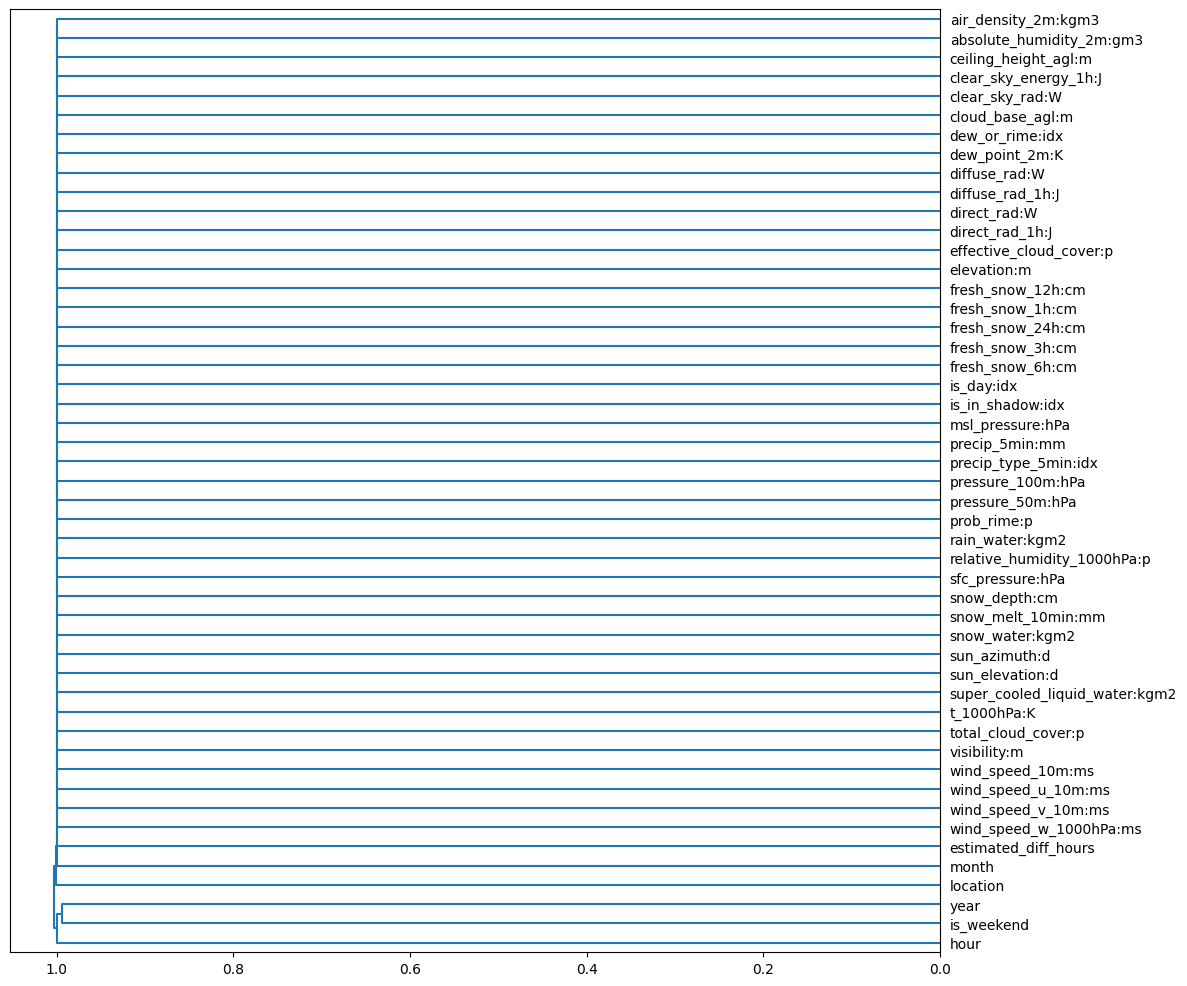

In [7]:
import autogluon.eda.auto as auto
auto.dataset_overview(train_data=X_train, test_data=X_test, label="y", sample=None)

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
y,10000,295.26029,787.46272,0.0,0.0,0.0,176.4,5365.36,float64,2539,,,float,


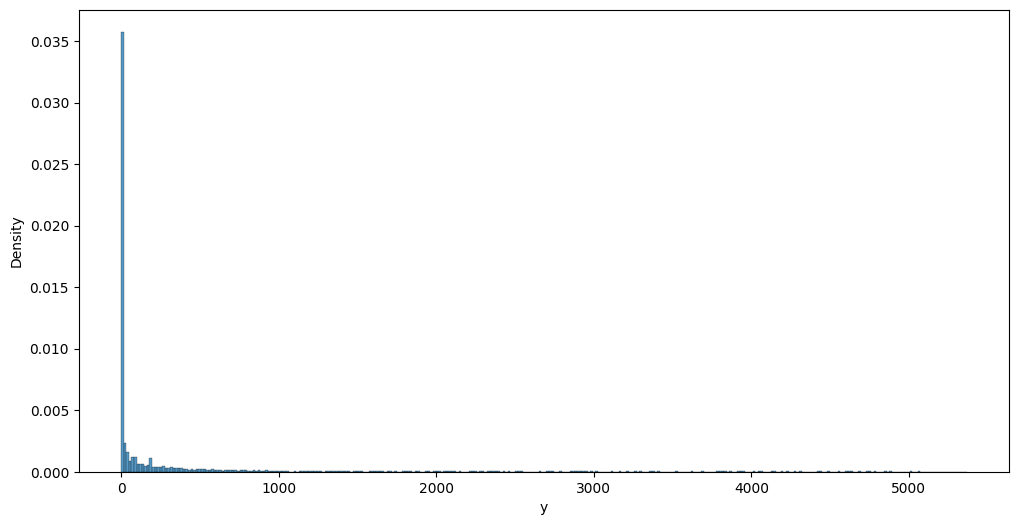

### Distribution fits for target variable
 - ⚠️ none of the [attempted](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) distribution fits satisfy specified minimum p-value threshold: `0.01`

### Target variable correlations

**`train_data` - `spearman` correlation matrix; focus: absolute correlation for `y` >= `0.5` (sample size: 10000)**

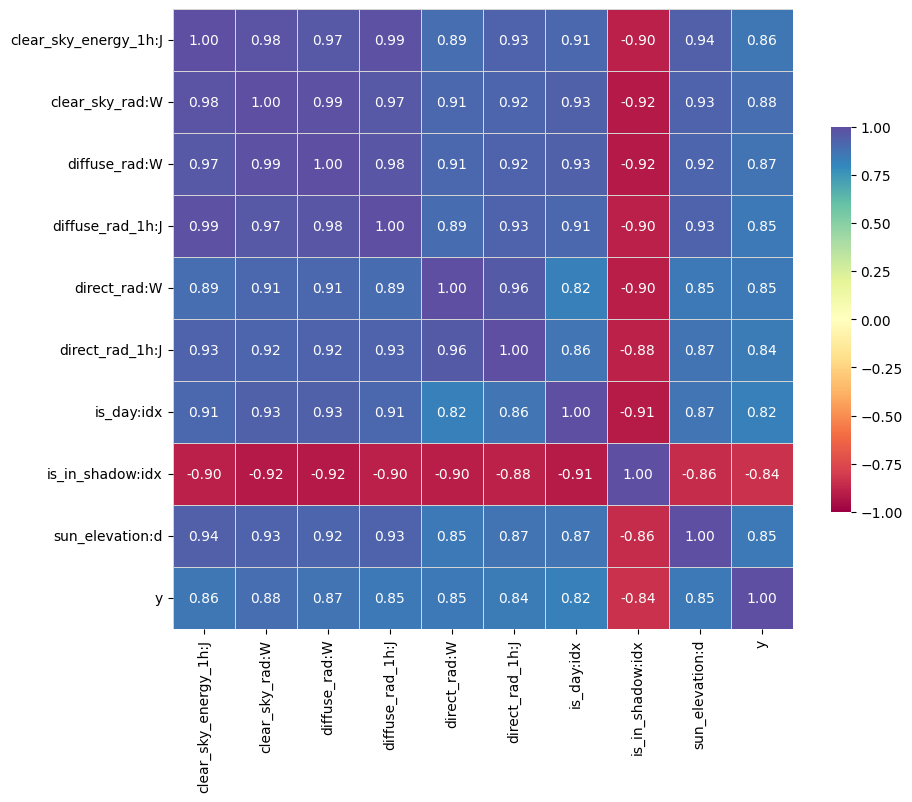

**Feature interaction between `clear_sky_rad:W`/`y` in `train_data` (sample size: 10000)**

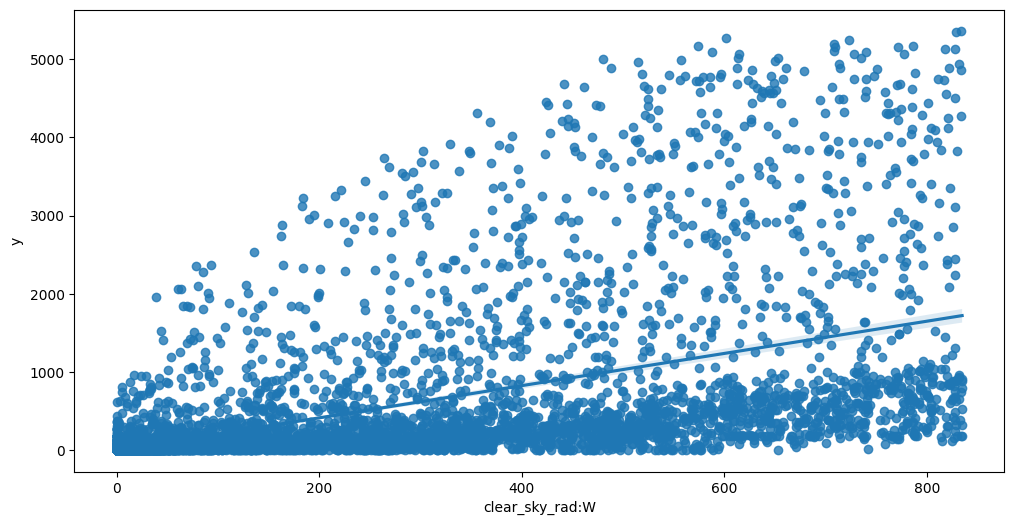

**Feature interaction between `diffuse_rad:W`/`y` in `train_data` (sample size: 10000)**

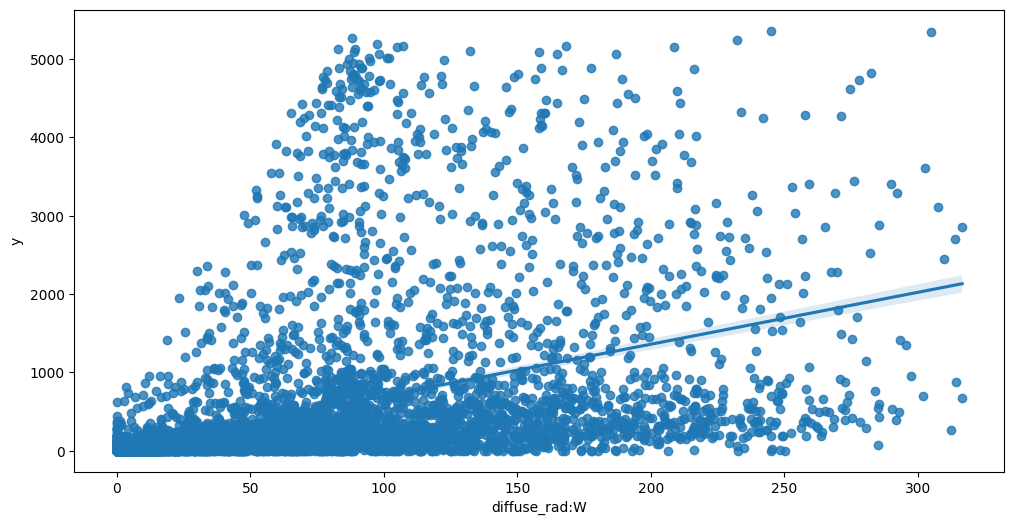

**Feature interaction between `clear_sky_energy_1h:J`/`y` in `train_data` (sample size: 10000)**

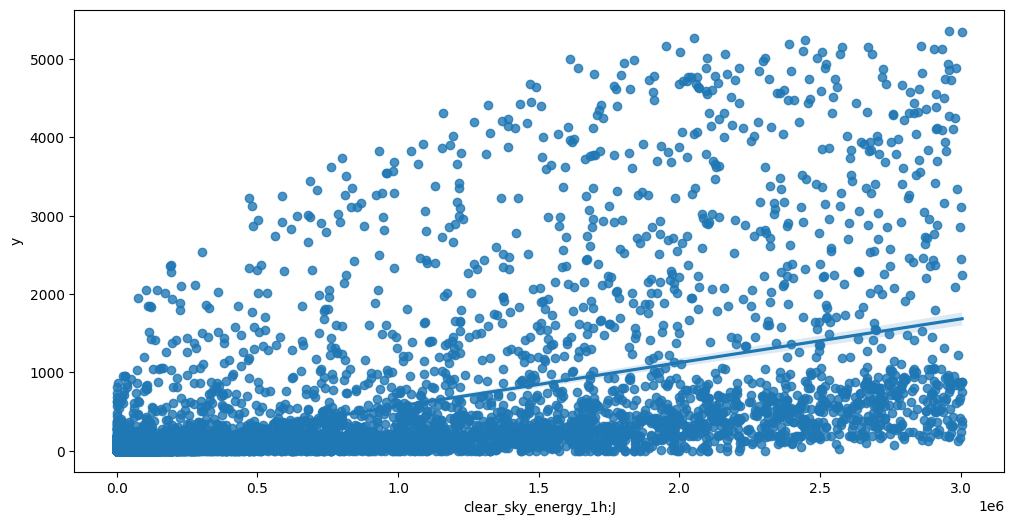

**Feature interaction between `direct_rad:W`/`y` in `train_data` (sample size: 10000)**

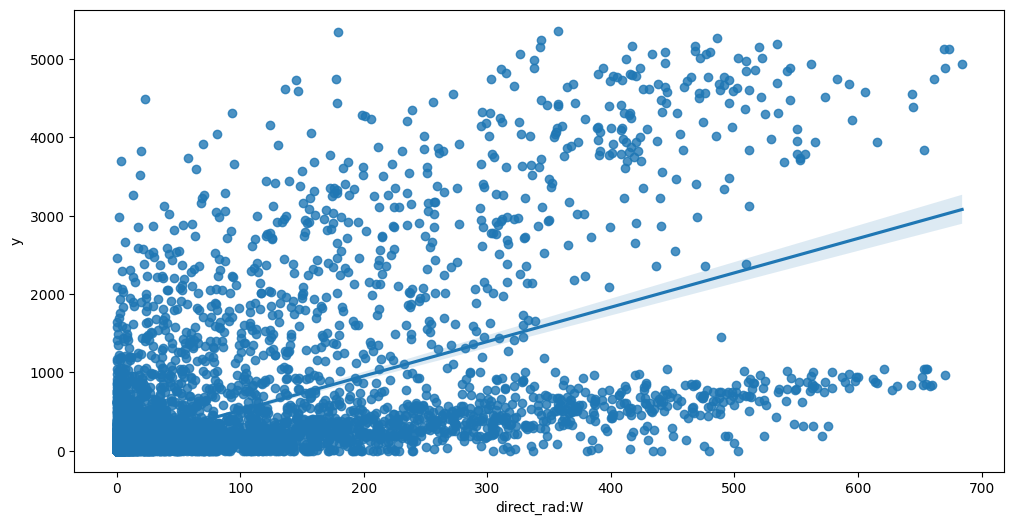

**Feature interaction between `diffuse_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

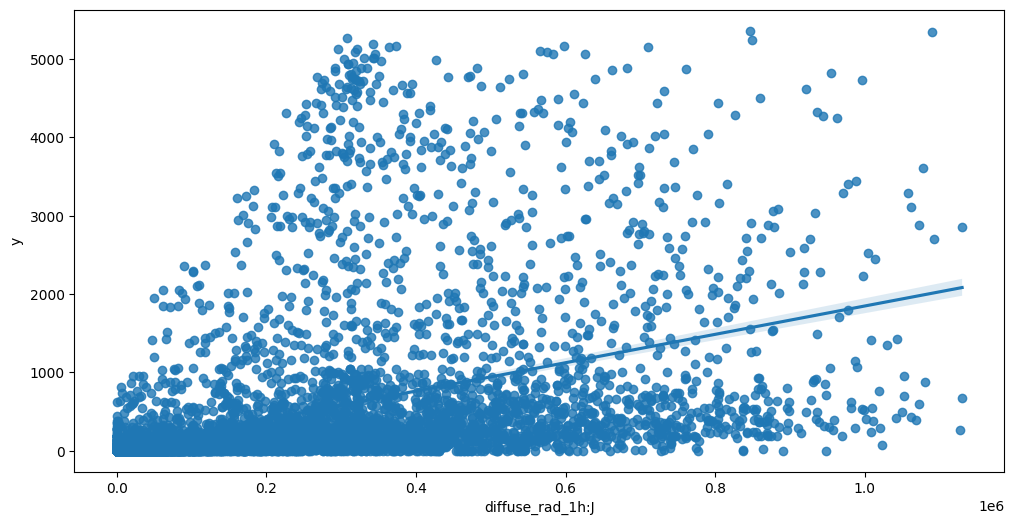

**Feature interaction between `sun_elevation:d`/`y` in `train_data` (sample size: 10000)**

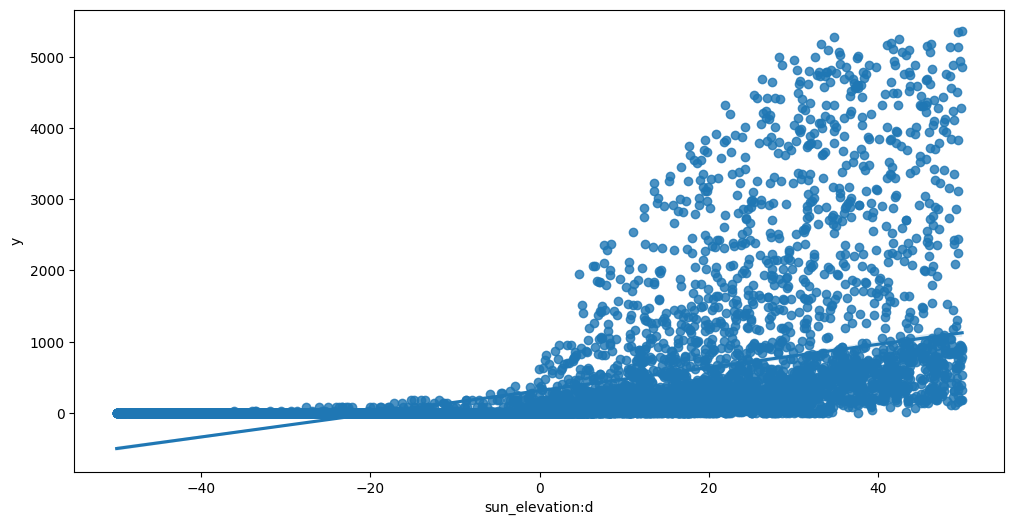

**Feature interaction between `direct_rad_1h:J`/`y` in `train_data` (sample size: 10000)**

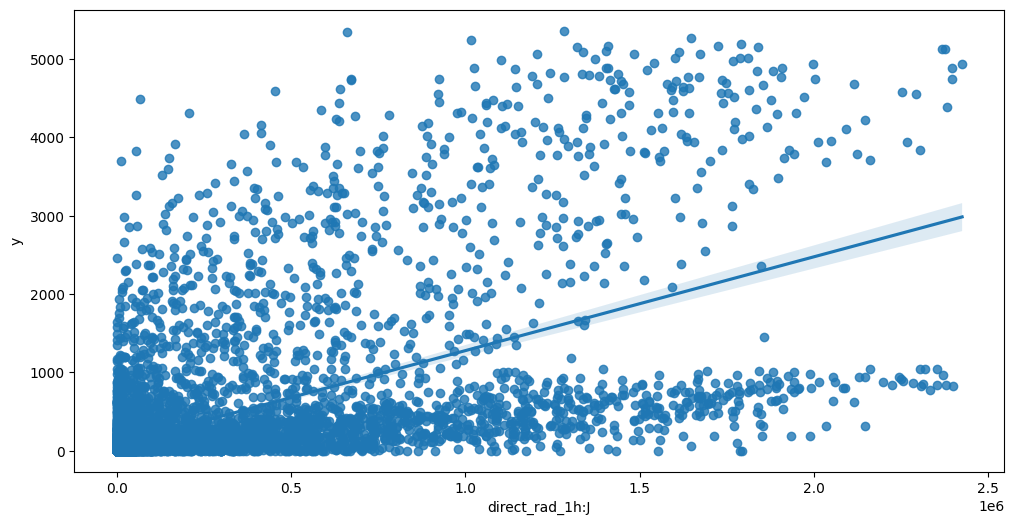

**Feature interaction between `is_day:idx`/`y` in `train_data` (sample size: 10000)**

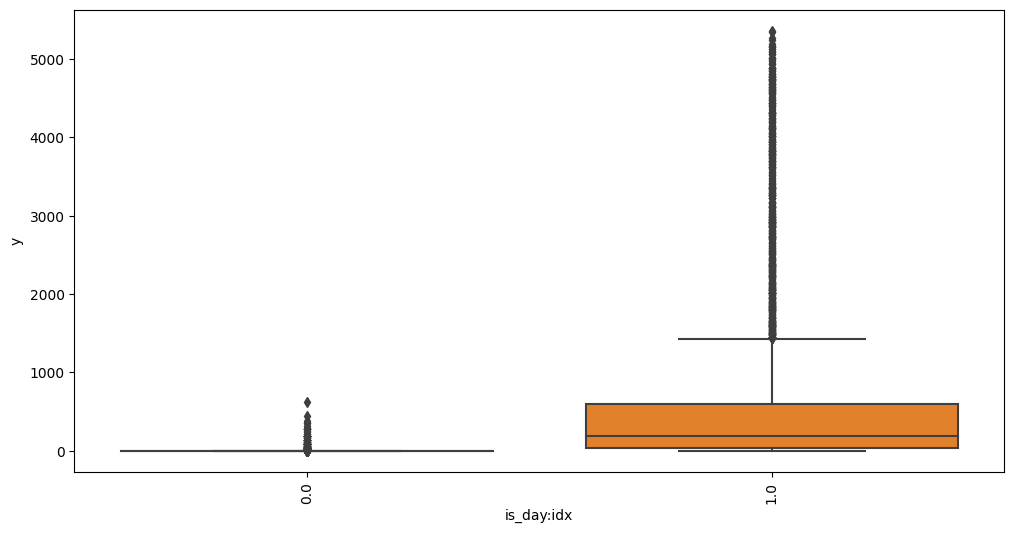

**Feature interaction between `is_in_shadow:idx`/`y` in `train_data` (sample size: 10000)**

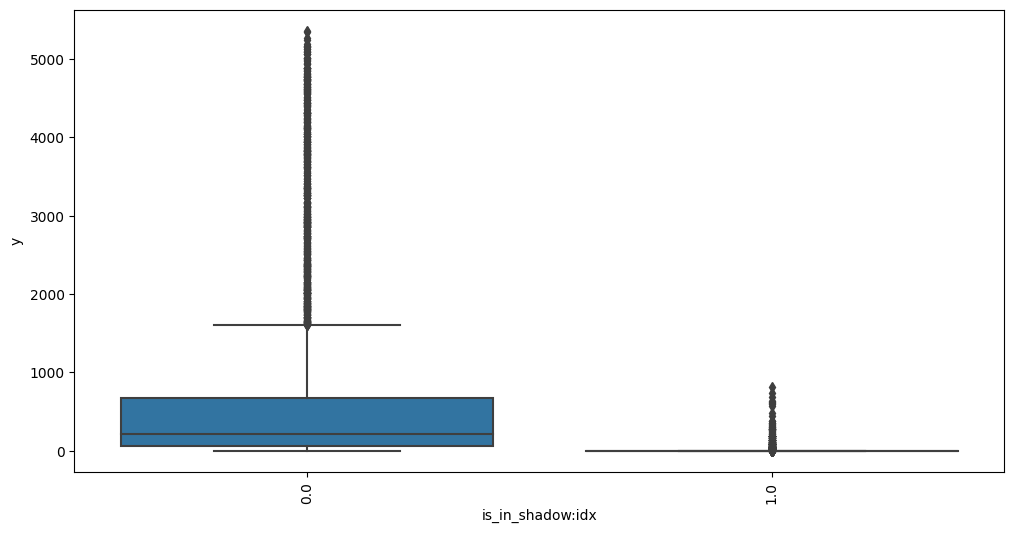

In [8]:
auto.target_analysis(train_data=X_train, label="y")

# Starting

In [9]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 78
Now creating submission number: 79
New filename: submission_79


In [10]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'



In [11]:
predictors = [None, None, None]

In [12]:
loc = "A"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[0] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_A/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.191-1 (2023-08-16)
Disk Space Avail:   102.31 GB / 105.09 GB (97.4%)
Train Data Rows:    34085
Train Data Columns: 49
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 630.59471, 1165.90242)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preproce

Training model for location A...


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 44 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  4 | ['hour', 'is_weekend', 'month', 'year']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 43 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])       :  3 | ['hour', 'month', 'year']
		('int', ['bool']) :  2 | ['elevation:m', 'is_weekend']
	0.3s = Fit runtime
	48 features in original data used to generate 

In [13]:

loc = "B"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[1] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_B/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.191-1 (2023-08-16)
Disk Space Avail:   102.31 GB / 105.09 GB (97.4%)
Train Data Rows:    32844
Train Data Columns: 49
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 96.82478, 193.94649)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess

Training model for location B...


			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 44 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  4 | ['hour', 'is_weekend', 'month', 'year']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 43 | ['absolute_humidity_2m:gm3', 'air_densi

In [14]:
loc = "C"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[2] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_79_C/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.191-1 (2023-08-16)
Disk Space Avail:   102.29 GB / 105.09 GB (97.3%)
Train Data Rows:    26095
Train Data Columns: 49
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 77.63106, 165.81688)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to prepro

Training model for location C...


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 1): ['location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 44 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])   :  4 | ['hour', 'is_weekend', 'month', 'year']
	Types of features in processed data (raw dtype, special dtypes):
		('float', [])     : 43 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
		('int', [])       :  3 | ['hour', 'month', 'year']
		('int', ['bool']) :  2 | ['elevation:m', 'is_weekend']
	0.2s = Fit runtime
	48 features in original data used to generate 

# Submit

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 51 / 51 | Rows = 93024 -> 93024
Loaded data from: X_test_raw.csv | Columns = 50 / 50 | Rows = 2160 -> 2160


In [16]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [17]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

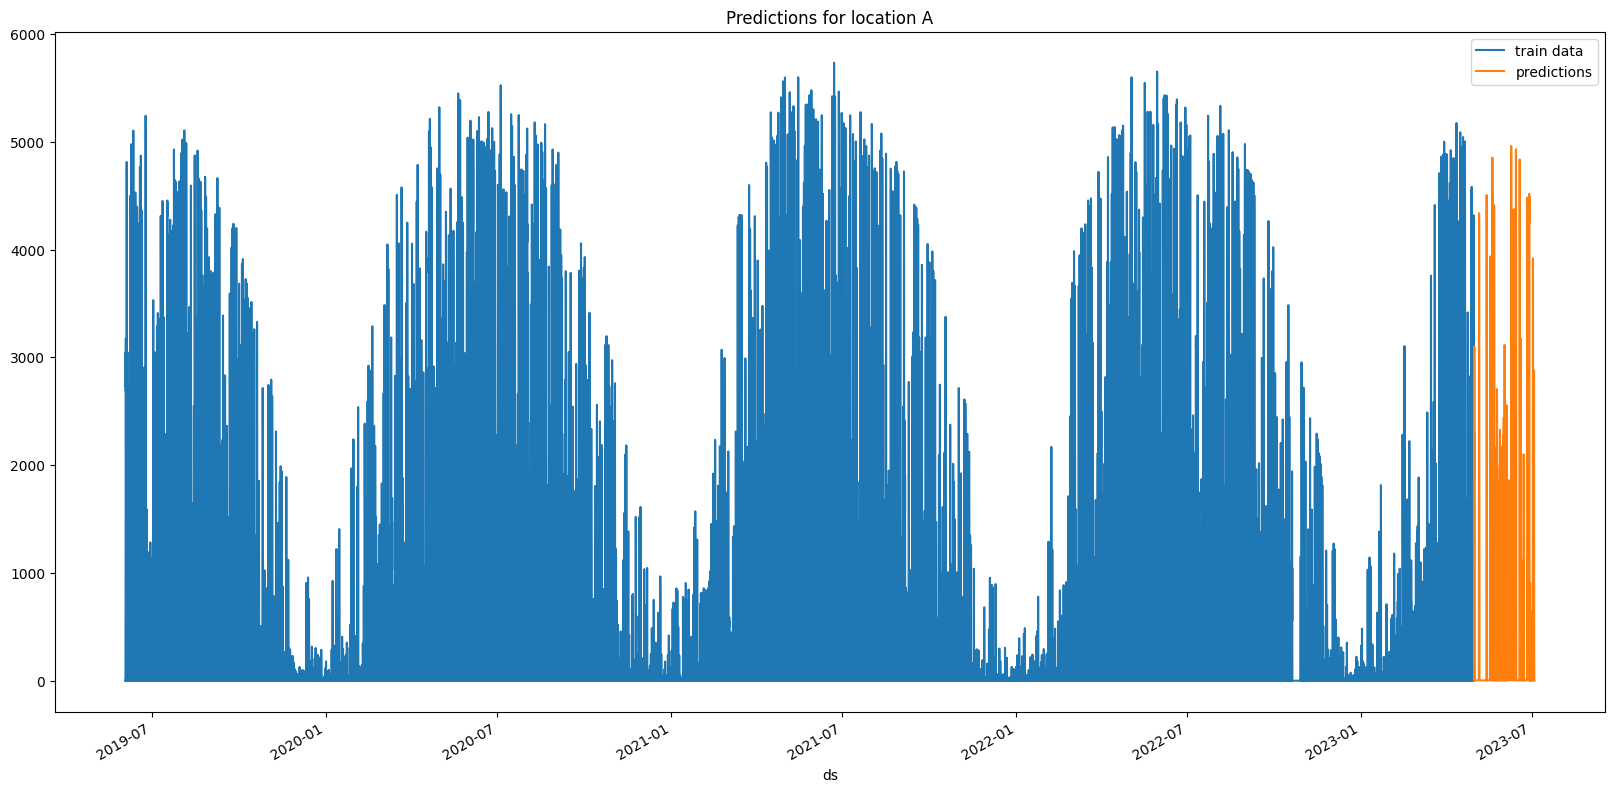

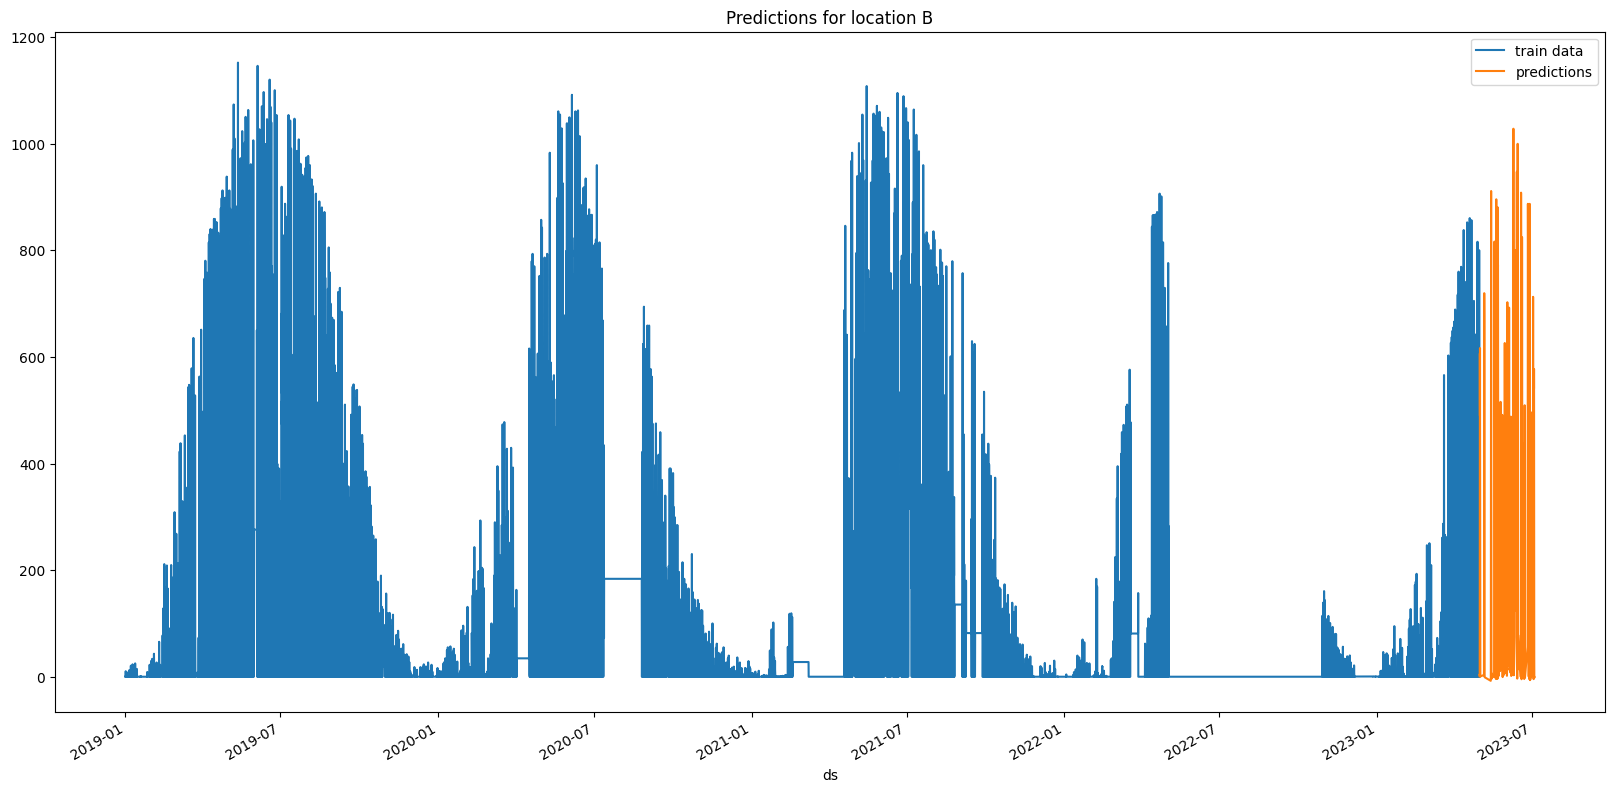

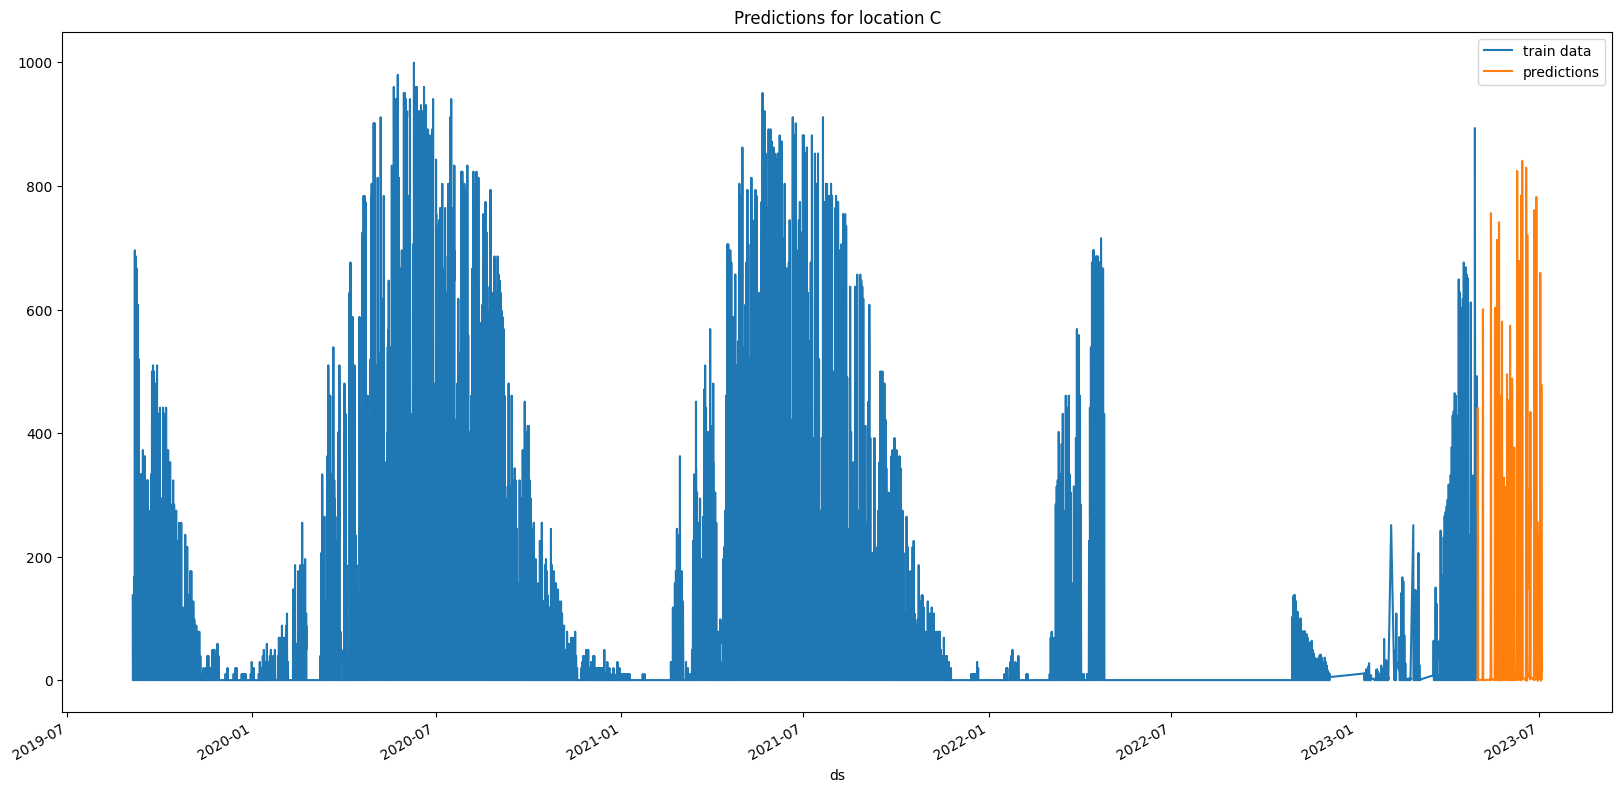

In [18]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [19]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,2.943763
1,1,3.026110
2,2,3.194726
3,3,31.010082
4,4,320.986023
...,...,...
715,2155,84.702835
716,2156,55.139187
717,2157,24.906143
718,2158,4.245795


In [20]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_79.csv


In [21]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
/opt/conda/lib/python3.10/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (2.9.2.1).
Your version must be at least (2.14.2) but less than (4.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in notebook_pdfs/submission_79_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_79_files/notebook_pdfs
[NbConvertApp] Writing 133464 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1389661 bytes to notebook_pdfs/submission_79.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_79.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [22]:
# feature importance
location="A"
split_time = pd.Timestamp("2022-10-28 22:00:00")
estimated = train_data_with_dates[train_data_with_dates["ds"] >= split_time]
estimated = estimated[estimated["location"] == location]
predictors[0].feature_importance(feature_stage="original", data=estimated, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'location']
Computing feature importance via permutation shuffling for 48 features using 4418 rows with 10 shuffle sets... Time limit: 600s...
	2760.95s	= Expected runtime (276.1s per shuffle set)
	394.83s	= Actual runtime (Completed 2 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
direct_rad:W,180.431262,2.859004,0.003566,2,309.121064,51.741461
clear_sky_rad:W,80.827215,0.142575,0.000397,2,87.244816,74.409614
diffuse_rad:W,55.637795,0.238150,0.000963,2,66.357439,44.918150
hour,33.464270,0.781495,0.005256,2,68.641029,-1.712489
sun_elevation:d,29.203752,0.031929,0.000246,2,30.640963,27.766542
sun_azimuth:d,25.334382,0.874841,0.007771,2,64.712817,-14.044052
direct_rad_1h:J,18.474804,0.007803,0.000095,2,18.826019,18.123588
cloud_base_agl:m,18.445307,0.664206,0.008103,2,48.342643,-11.452029
total_cloud_cover:p,16.539757,0.468122,0.006370,2,37.610901,-4.531387
effective_cloud_cover:p,13.819135,0.329330,0.005363,2,28.642987,-1.004718


In [23]:
# feature importance
observed = train_data_with_dates[train_data_with_dates["ds"] < split_time]
observed = observed[observed["location"] == location]
predictor.feature_importance(feature_stage="original", data=observed, time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'location']
Computing feature importance via permutation shuffling for 48 features using 5000 rows with 10 shuffle sets... Time limit: 600s...
	2648.12s	= Expected runtime (264.81s per shuffle set)
	443.79s	= Actual runtime (Completed 2 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
clear_sky_rad:W,43.516284,0.365936,0.001893,2,59.987841,27.044727
direct_rad:W,17.079492,0.322175,0.004245,2,31.581257,2.577728
sun_elevation:d,16.576847,0.135748,0.001843,2,22.687153,10.466541
clear_sky_energy_1h:J,14.724154,0.045642,0.000698,2,16.778584,12.669723
diffuse_rad:W,8.557562,0.396116,0.010415,2,26.387585,-9.272460
direct_rad_1h:J,6.191296,0.233848,0.008499,2,16.717285,-4.334693
relative_humidity_1000hPa:p,2.082750,0.114568,0.012375,2,7.239693,-3.074193
diffuse_rad_1h:J,1.331459,0.307341,0.051501,2,15.165527,-12.502609
is_day:idx,1.213489,0.110661,0.020497,2,6.194569,-3.767591
sun_azimuth:d,1.081176,0.003464,0.000721,2,1.237093,0.925259


In [24]:
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_with_feature_importance.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
/opt/conda/lib/python3.10/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (2.9.2.1).
Your version must be at least (2.14.2) but less than (4.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in notebook_pdfs/submission_79_with_feature_importance_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_79_with_feature_importance_files/notebook_pdfs
[NbConvertApp] Writing 138959 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1395293 bytes to notebook_pdfs/submission_79_with

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_79_with_feature_importance.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [26]:
import subprocess

def execute_git_command(directory, command):
    """Execute a Git command in the specified directory."""
    try:
        result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
        return result.decode('utf-8').strip(), True
    except subprocess.CalledProcessError as e:
        print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
        return e.output.decode('utf-8').strip(), False

git_repo_path = "."

new_filename = "henrik"

branch_name = new_filename

# add datetime to branch name
branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

commit_msg = "run result"

execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# Navigate to your repo and commit changes
execute_git_command(git_repo_path, ['add', '.'])
execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# Push to remote
output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# If the push fails, try setting an upstream branch and push again
if not success and 'upstream' in output:
    print("Attempting to set upstream and push again...")
    execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
    execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

execute_git_command(git_repo_path, ['checkout', 'main'])

Git command failed with message: Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: empty ident name (for <jupyter@instance-20231005-173718.us-central1-a.c.skog-ai.internal>) not allowed


("Switched to branch 'main'\nM\t.ipynb_checkpoints/autogluon_each_location-checkpoint.ipynb\nM\tX_test_raw.csv\nM\tX_train_raw.csv\nM\tautogluon_each_location.ipynb\nA\tnotebook_pdfs/submission_79.pdf\nA\tnotebook_pdfs/submission_79_with_feature_importance.pdf\nA\tsubmissions/submission_79.csv\nYour branch is up to date with 'origin/main'.",
 True)